# Transfer Learning for Computer Vision Tutorial
**Adapted from [code](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by [Sasank Chilamkurthy](https://chsasank.github.io).**  
License: BSD.

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [3]:
%matplotlib inline

### Import relevant packages

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
present and future **Israeli politicians**. We have about ~100 training images for each of our 9 politician.
Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

In [5]:
!mkdir data

In [6]:
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

In [7]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip -d data/

### Datasets definition

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
       transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = r'./data/israeli_politicians/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 929
    Root location: ./data/israeli_politicians/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



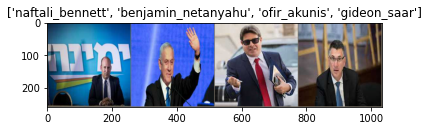

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):    
    # Record the train/evaluate mode of the model, to restore it after we're done
    was_training = model.training
    # Set the model mode to evaluate
    model.eval()
    
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad(): # No need to collect gradients when generating predictions
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        # Restore the model's train/evaluate mode
        model.train(mode=was_training)

## Finetuning the network
Load a pretrained model and reset final fully connected layer.




In [39]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.
model = models.resnet18(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)

In [40]:
# for layer in list(model.children())[:-1]:
#     for param in layer.parameters():
#         param.requires_grad = False

In [44]:
last_layer = list(model.children())[-1]
if hasattr(last_layer, 'in_features'):
  num_ftrs = last_layer.in_features
else:
  num_fturs = last_layer[-1].in_features

In [47]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 30

### Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [48]:
model = train_model(model, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5828 Acc: 0.8396


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5157 Acc: 0.8419

Epoch 1/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.2087 Acc: 0.9473


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.6620 Acc: 0.7778

Epoch 2/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1984 Acc: 0.9419


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5210 Acc: 0.8291

Epoch 3/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1277 Acc: 0.9688


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5797 Acc: 0.8248

Epoch 4/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1625 Acc: 0.9537


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.6331 Acc: 0.7949

Epoch 5/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1036 Acc: 0.9763


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.6143 Acc: 0.8291

Epoch 6/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1358 Acc: 0.9602


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5878 Acc: 0.8419

Epoch 7/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0867 Acc: 0.9795


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5177 Acc: 0.8718

Epoch 8/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0798 Acc: 0.9763


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5030 Acc: 0.8718

Epoch 9/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0542 Acc: 0.9882


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4767 Acc: 0.8803

Epoch 10/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0740 Acc: 0.9785


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5028 Acc: 0.8718

Epoch 11/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0405 Acc: 0.9903


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5092 Acc: 0.8547

Epoch 12/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0462 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5110 Acc: 0.8590

Epoch 13/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0362 Acc: 0.9946


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5413 Acc: 0.8632

Epoch 14/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0488 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5133 Acc: 0.8632

Epoch 15/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0503 Acc: 0.9882


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4514 Acc: 0.8590

Epoch 16/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0486 Acc: 0.9828


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5172 Acc: 0.8632

Epoch 17/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0450 Acc: 0.9882


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5066 Acc: 0.8590

Epoch 18/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0586 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4592 Acc: 0.8718

Epoch 19/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0445 Acc: 0.9914


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4502 Acc: 0.8632

Epoch 20/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0416 Acc: 0.9860


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5144 Acc: 0.8547

Epoch 21/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0458 Acc: 0.9860


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4632 Acc: 0.8632

Epoch 22/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0401 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4663 Acc: 0.8590

Epoch 23/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0674 Acc: 0.9806


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5007 Acc: 0.8504

Epoch 24/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0518 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4850 Acc: 0.8632

Epoch 25/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0482 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5462 Acc: 0.8590

Epoch 26/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0768 Acc: 0.9785


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5409 Acc: 0.8504

Epoch 27/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0335 Acc: 0.9914


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.4670 Acc: 0.8547

Epoch 28/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0571 Acc: 0.9871


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5360 Acc: 0.8632

Epoch 29/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0654 Acc: 0.9828


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.5358 Acc: 0.8675

Training complete in 3m 59s
Best val Acc: 0.880342


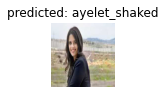

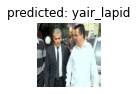

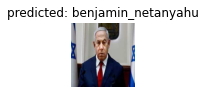

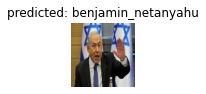

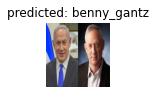

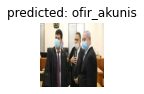

In [49]:
visualize_model(model)

## NN as a fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, 
                         criterion, 
                         optimizer_conv,
                         exp_lr_scheduler, 
                         num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Comparison with a model trained from scratch
In this section, compare the performance of the pretrained model with those of a model trained from scratch.  
Plot the train and validation loss and accuracy with time.

Note: To do this, you will need to modify `train_model()` to return the validation accuracy.

## Data Augmentation
Manually labeling can be expensive, both in terms of money and of time. Data augmentations serve to increase the amount of data available for the classifier without requiring labeling more images.  

The torch vision package allows easy augmentation of images using the data transforms.  
Use and adapt the code below to try different augmentations, and discuss the results and the model improvements you got from these augmentations.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Model Architectures
In the course we'll cover in depth various DL architectures suggested to perform image classification. Among other things, these networks differ in depth (the number of layers), the number of weights (the network power), the composing layers, and more.  
In the figure below, you can see the performance of different network architectures on the ImageNet Image Classification task, and the number of flops (atomic computations) required for them. 

TODO: Add image.

In our code above we've used the `mobilenet` architecture.  
See if you can increase model performance by using alternative architectures.  
Pay attention to the input dimensions that each network architecture expects.

## Perform Error Analysis 
Error Analysis is an extremely important practice in Machine Learning research. It is rare that our base model works great out of the box. Proper error analysis helps us detect and fix issues in our DL code, data preprocessing and even in the data itself.

#### Review examples of top errors
One of the basic techniques of Error Analysis is manually reviewing the top errors of the model - samples where the model was most confident about one class, but the true label was different.  
Plot the top 10 errors of the model for each true class.  
Do you spot any issue or pattern?  
Try to see if you can improve the performance of the model following your insights.

## Design your own Neural Network Architecture
Take a stab at building your own NN architecture.  
To allow you to experiment quickly, we'll limit it to 8 layers max, and up to 10 million parameters.  
Train it only on our provided images - we'll present the winner with the best results on the validation set!

## Plot a 2D map of embeddings
In this section, we'll use the pretrained ImageNet network as a feature extractor, and project the embedding into 2D using the UMAP algorithm. We are interested to see if similar concepts are indeed mapped to similar locations in 2D.

Install the UMAP package.

Extract embeddings for all images in the validation set and keep them in an array.

UMAP uses concepts from topology to provide unsupervised (or supervised) dimensionality reduction, that attempts to preserve distances between a point and its N nearest neighbors (where N is a hyperparameter). It is faster and more robust than t-SNE, and often gives better results. 

Use UMAP to lower the dimension to 2D.  
Experiment with different values of neighbors. 

Use plotly to display an interactive scatter graph of the projected points in 2D.  

Make sure that hovering over each input will show the associated image. 
You can also color each point according to its true true label, and use a different marker ('x', 'o') for each point according to its predicted label.


Discuss your results.